In [18]:
import pandas as pd
import numpy as np
import pickle
import re


from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
class Data:
    """
    Load the data categorize the columns to categorical and numerical
    """
    def __init__(self, filepath: str = None, targetcol: str = None):
        self.data = pd.read_csv(filepath)
        self.targetcol = targetcol

    def get_numericals(self):
        self.num_cols = list(self.data.dtypes[
            (self.data.dtypes == 'int64') | (self.data.dtypes == 'float64')| 
            (self.data.dtypes == 'int32') | (self.data.dtypes == 'float32')|
            (self.data.dtypes == 'int16') | (self.data.dtypes == 'float16')|
            (self.data.dtypes == 'int8')].keys())
        if self.targetcol in self.num_cols:
            self.num_cols.remove(self.targetcol)
        self.cat_cols = list(set(self.data.columns).difference(self.num_cols))
        if self.targetcol in self.cat_cols:
            self.cat_cols.remove(self.targetcol)
        return self.num_cols, self.cat_cols

    def get_inputs(self):
        num_cols, cat_cols = self.get_numericals()
        return num_cols, self.targetcol, self.data, cat_cols

In [20]:
def bootstrap_confidence_lasso_ridge_(model, n_iterations, data):
    """
    get confidence score of the model using bootstrapping.
    args:
        targetcol: target column name
        data: whole cleaned dataframe
        num_cols: List of numerical column names
        cat_cols: List of categorical column names
        n_iterations: number of iteration to run bootstrapping
    return:
        Confidence interval: Lower and upper quantile.
    """
    try:
        scores = []
        mae = []
        for i in range(n_iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[num_cols+cat_cols], data[targetcol], test_size=0.2,random_state=i)
            X_train = X_train.fillna(X_train.median())
            X_test = X_test.fillna(X_train.median())
            model = model.fit(X_train, y_train)
            scores.append(model.score(X_test,y_test))
            mae.append(mean_absolute_error(model.predict(X_test), y_test))
        lower_mae, upper_mae = np.quantile(mae, q = 0.025), np.quantile(mae, q = 0.975)
        lower_score, upper_score = np.quantile(scores, q = 0.025), np.quantile(scores, q = 0.975)
        
        return lower_score, upper_score, lower_mae, upper_mae
    except:
        print("\n Not enough resampled data test data may have some new categories.")
        return 0,0

In [21]:
def fit_lasso_model(X_train:pd.DataFrame=None, y_train:pd.DataFrame=None):
    """
    Train a Lasso Model with cross validation having many different alpha parameters.
    L(β) = sum (yi − hat_yi)^2 + lambda * sum |beta_j|
    This function is not differentiable in its parameters. Hence there is no closed form of the estimator.
    
    args:
        X_train: training data dataframe
        y_train: Series of train target actual values
    return:
        ridge_model:
        alpha_: best alpha
        explanation: 2D sorted numpy array with (features, features coefficients) 
    """
    lasso_model = LassoCV(cv=10, alphas=[1e-3, 1e-2, 1e-1, 1, 10, 20]).fit(X_train, y_train)
    train_predictions = lasso_model.predict(X_train)
    train_r2 = lasso_model.score(X_train,y_train)
    print("Best Regularization Constant chosen by Lasso model:", lasso_model.alpha_)
    print("Lasso Training Model Score:", train_r2)
    feat_selected = list(X_train.columns[lasso_model.coef_.nonzero()])
    explanation = np.append(np.array(feat_selected).reshape(-1,1),
                                             lasso_model.coef_[lasso_model.coef_.nonzero()].reshape(-1,1).astype('float'),1)
    explanation[:,1] = np.abs(explanation[:,1].astype(np.float64))#.round(2)
    explanation = explanation[explanation[:,1].argsort()]
    hyperparameters = {'alpha':lasso_model.alpha_}
    return lasso_model, hyperparameters, train_predictions, train_r2, explanation

def fit_ridge_model(X_train:pd.DataFrame=None, y_train:pd.DataFrame=None):
    """
    Train a Ridge L2 regularization Model with cross validation having many different alpha parameters.
    L(β) = sum (yi − hat_yi)^2 + lambda * sum beta_j^2
    This function is differentiable in its parameters. Closed form of the estimator:
    beta = ((X^T)X + lambda I)^-1 (X.T)y
    
    args:
        X_train: training data dataframe
        y_train: Series of train target actual values
    return:
        ridge_model:
        alpha_: best alpha
        explanation: 2D sorted numpy array with (features, features coefficients)
    """
    ridge_model = RidgeCV(cv=10, alphas=[1e-3, 1e-2, 1e-1, 1, 10, 20]).fit(X_train, y_train)
    train_predictions = ridge_model.predict(X_train)
    train_r2 = ridge_model.score(X_train,y_train)
    print("Best Regularization Constant chosen by Ridge model:", ridge_model.alpha_)
    print("Ridge Training Model Score:", train_r2)
    feat_selected = list(X_train.columns[ridge_model.coef_.nonzero()])
    explanation = np.append(np.array(feat_selected).reshape(-1,1),
                                             ridge_model.coef_[ridge_model.coef_.nonzero()].reshape(-1,1),1)
    explanation[:,1] = np.abs(explanation[:,1].astype(np.float64))#.round(2)
    explanation = explanation[explanation[:,1].argsort()]
    hyperparameters = {'alpha':ridge_model.alpha_}
    return ridge_model, hyperparameters, train_predictions, train_r2, explanation

def predict_and_evaluate(model, X_test:pd.DataFrame=None, y_test:pd.DataFrame=None):
    """
    Do prediction using the model and then calculate the R2
    args:
        model: fitted model object
        X_test: DataFrame of Test data samples
        y_test: Series of test target actual values
    return:
        predictions: array of test predictions
        test_r2: R2 for test data    
    """
    predictions = model.predict(X_test)
    test_r2 = model.score(X_test, y_test)
    return predictions, test_r2

def predict_unknown(model, X_test:pd.DataFrame=None):
    """
    Do prediction using the model and then calculate the R2
    args:
        model: fitted model object
        X_test: DataFrame of Test data samples
    return:
        predictions: array of test predictions
    """
    predictions = model.predict(X_test)
    return predictions

In [6]:
### Fit model
##1. Get Train Predictions DOne
# 2. test predictions Done
# 3. Train and test R2 Done
# 4. Explanation Done
# 5. Confidence interval Done
# 6. Uncertainty ????? Prediction Interval

Best Regularization Constant chosen by Ridge model: 10.0
Ridge Training Model Score: 0.7257430428212469
ridge_test_r2:0.6350737618447151
CI R2:(0.43754289312873806, 0.6887369741972923)

CI MAE:(0.35336703166924593, 0.41633246454376843)

Best Regularization Constant chosen by Lasso model: 0.01
Lasso Training Model Score: 0.8418864053672319
lasso_test_r2:0.6682265155512939
CI R2:(0.40608995010088633, 0.4852876122226059)
CI MAE:(0.3257701911312277, 0.4852876122226059)


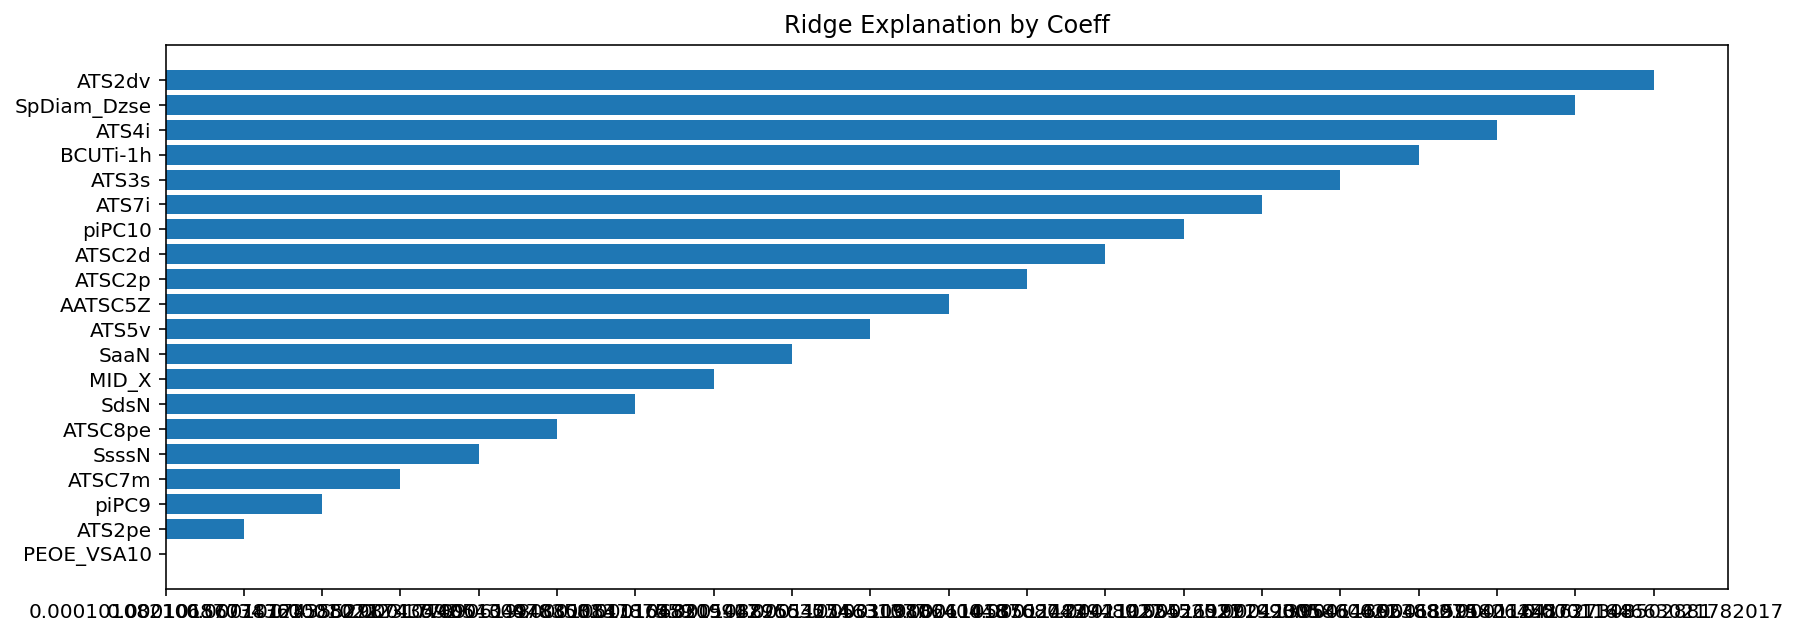

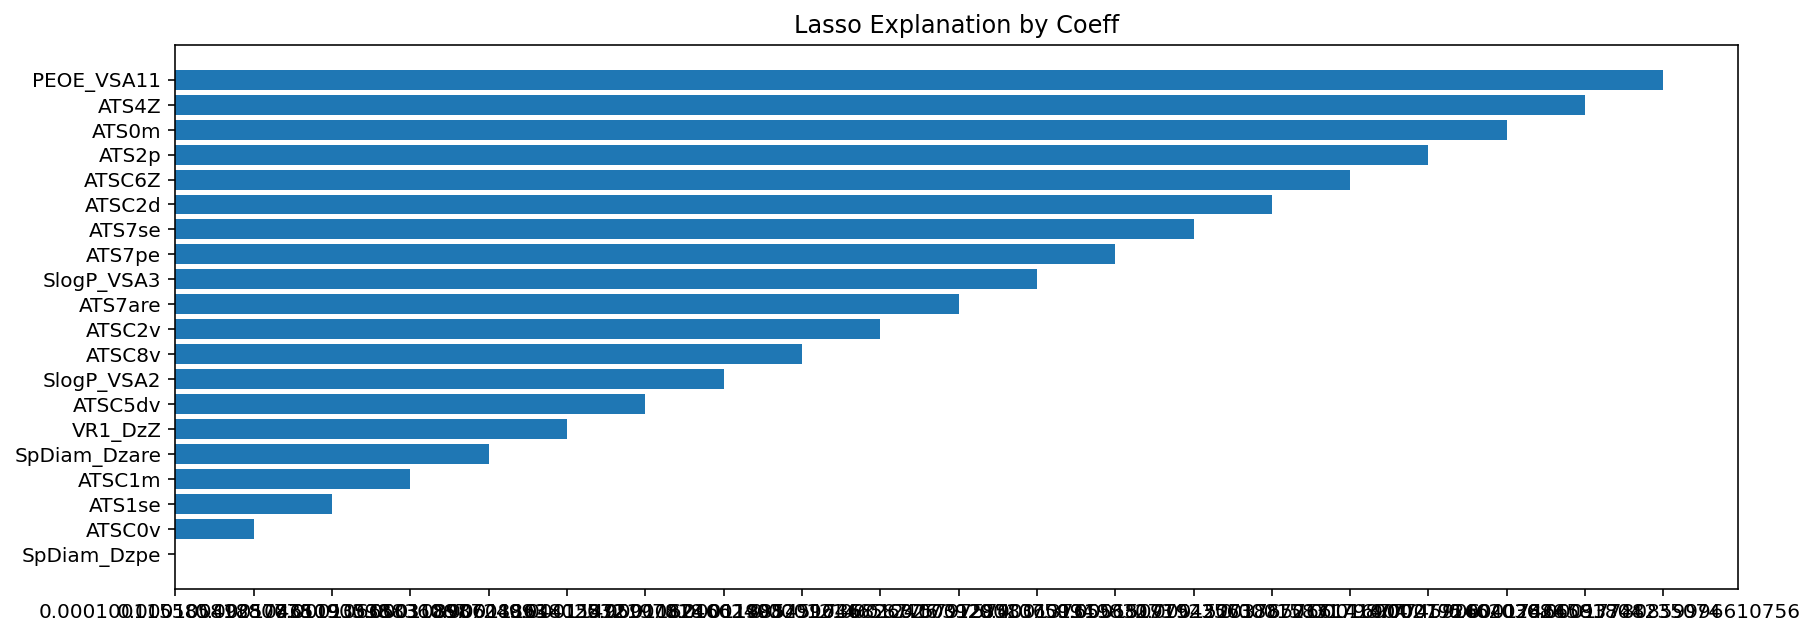

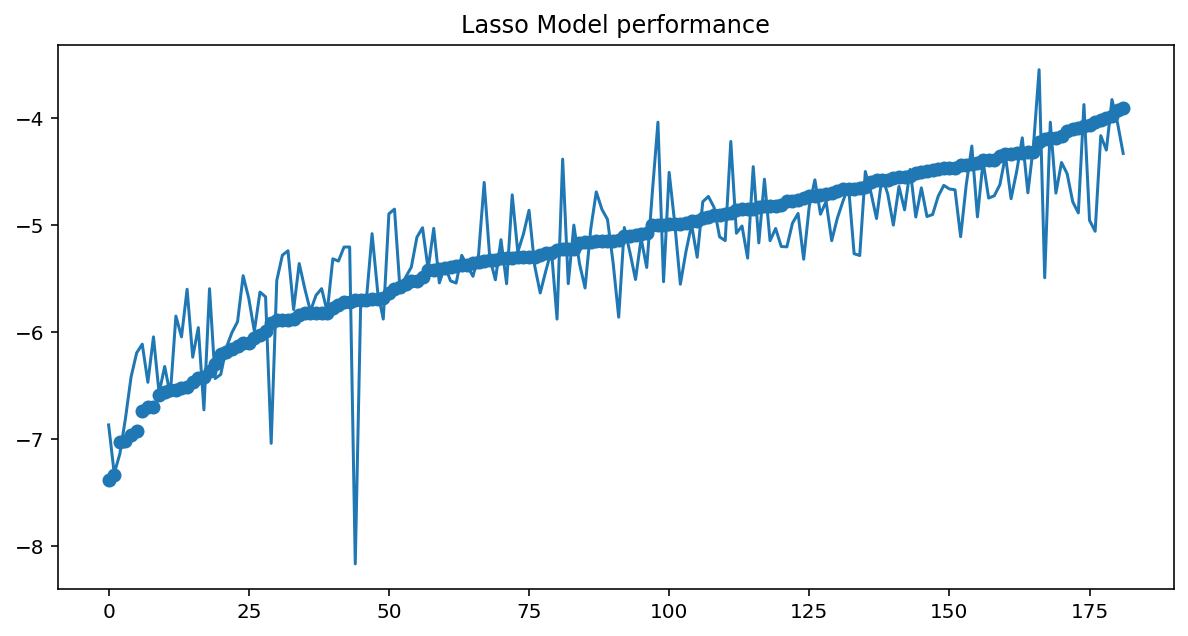

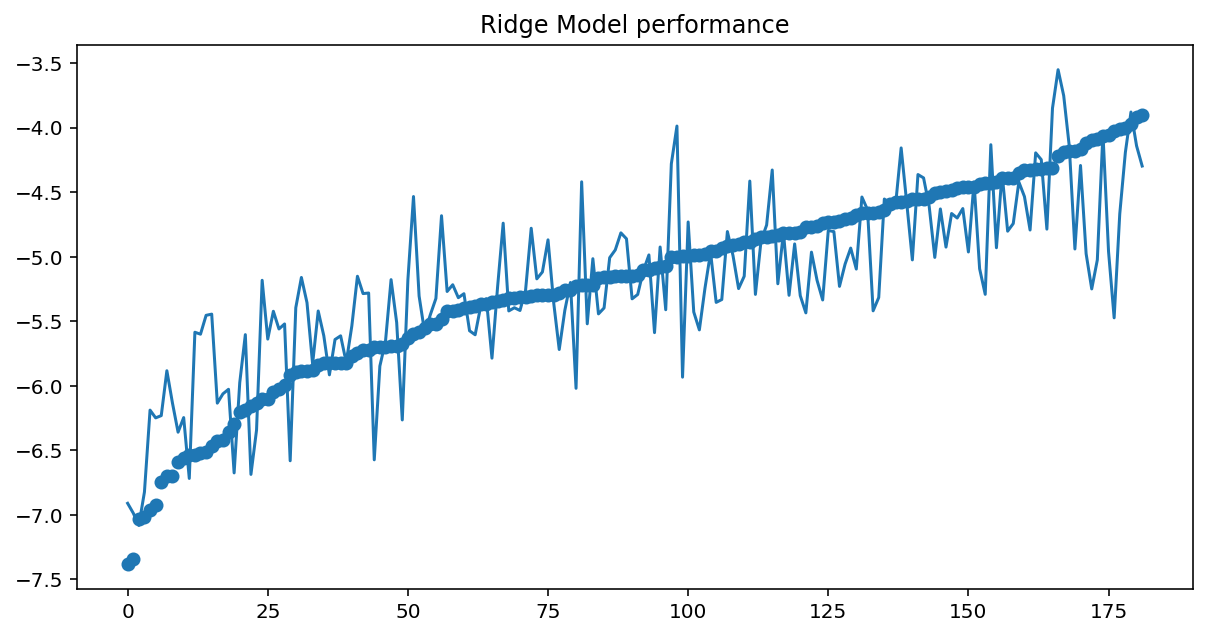

In [22]:
if __name__ == '__main__':
    data_obj = Data("/Users/lingrajsvannur/Desktop/DrugDiscovery/propertyprediction/mordred1826_caco2_wang.tab.csv","property")
    num_cols, targetcol, data, cat_cols = data_obj.get_inputs()
    data = data.fillna(data.median())
    X_train, X_test, y_train, y_test = train_test_split(data[num_cols+cat_cols], data[targetcol], test_size=0.2, random_state=0)
    ridge_model, hyperparameters, ridge_train_predictions, ridge_train_r2, ridge_explanation = fit_ridge_model(X_train, y_train)
    ridge_predictions, ridge_test_r2 = predict_and_evaluate(ridge_model, X_test, y_test)
    print(f"ridge_test_r2:{ridge_test_r2}")
    lower_score, upper_score, lower_mae, upper_mae = bootstrap_confidence_lasso_ridge_(ridge_model, 10, data)
    print(f"CI R2:{lower_score,upper_score}\n")
    print(f"CI MAE:{lower_mae,upper_mae}\n")

    lasso_model, hyperparameters, lasso_train_predictions, lasso_train_r2, lasso_explanation = fit_lasso_model(X_train, y_train)
    lasso_predictions, lasso_test_r2 = predict_and_evaluate(lasso_model, X_test, y_test)
    print(f"lasso_test_r2:{lasso_test_r2}")
    lower_score, upper_score, lower_mae, upper_mae = bootstrap_confidence_lasso_ridge_(lasso_model, 10, data)
    print(f"CI R2:{lower_score,upper_mae}")
    print(f"CI MAE:{lower_mae,upper_mae}")
    
    lasso_model_performance = np.append(np.array(lasso_predictions).reshape(-1,1), np.array(y_test).reshape(-1,1),1)
    lasso_model_performance = lasso_model_performance[lasso_model_performance[:,1].argsort()]
    
    ridge_model_performance = np.append(np.array(ridge_predictions).reshape(-1,1), np.array(y_test).reshape(-1,1),1)
    ridge_model_performance = ridge_model_performance[ridge_model_performance[:,1].argsort()]
    
    filename = 'lasso_model.pkl'
    pickle.dump(lasso_model, open(filename, 'wb'))
    lasso_model = pickle.load(open(filename, 'rb'))

    filename = 'ridge_model.pkl'
    pickle.dump(ridge_model, open(filename, 'wb'))
    ridge_model = pickle.load(open(filename, 'rb'))
    
    fig, ax = plt.subplots(figsize=(14,5))
    plt.barh(ridge_explanation[:,0][:20],ridge_explanation[:,1][:20])
    plt.title('Ridge Explanation by Coeff')
    plt.show()
    fig, ax = plt.subplots(figsize=(14,5))
    plt.barh(lasso_explanation[:,0][:20],lasso_explanation[:,1][:20])
    plt.title('Lasso Explanation by Coeff')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10,5))
    plt.plot(np.arange(len(lasso_model_performance)),lasso_model_performance[:,0])
    plt.scatter(np.arange(len(lasso_model_performance)),lasso_model_performance[:,1])
    plt.title('Lasso Model performance')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10,5))
    plt.plot(np.arange(len(ridge_model_performance)),ridge_model_performance[:,0])
    plt.scatter(np.arange(len(ridge_model_performance)),ridge_model_performance[:,1])
    plt.title('Ridge Model performance')
    plt.show()